In [2]:
import numpy as np
from collections import namedtuple
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import random

In [3]:
Node = namedtuple('Node', ['t', 'm'])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class BinomialTree:
    def __init__(self, s0=100, K=100, r=0.02, sigma=0.1, maturity=1, n=10, D=1):
        self.s0 = s0
        self.K = K  # ATM strike price
        self.r = r  # riskless interest rate
        self.sigma = sigma  # stocks vol
        self.T = maturity  # option's maturity
        self.n = n  # total steps of Tree
        self.delta_t = self.T / self.n

        ## Calculate key elements in Tree generalization
        self.u = np.exp(self.sigma * np.sqrt(self.delta_t))  # Move up steps
        self.d = 1 / self.u
        self.R = np.exp(self.r * self.delta_t)  # Discount ratio of each step
        self.p = (self.R - self.d) / (self.u - self.d)  # Prob of moving up

        ## Self state
        self.node = None  # current state: Node(t, m)
        self.hedging_pos = 0  # Started hedging position
        self.D = D  # Holding position of derivatives

        ## Env state
        self.grid = None  # Store the tree's Node:  {time t: [Node(t, m1), Node(t, m2) ...]}
        self.observation_space = None  # Dict: {Node(t, m): (stock_price, option_price, {'exercise': bool})}
        self.action_space = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        self.state_dim = 2  # State: (stock_price, option_value)
        self.action_dim = len(self.action_space)

    def get_price(self, node):  # Return the stock price at Node(i,j)
        return self.s0 * np.power(self.u, node.m)

    def _generate(self):
        grid = {}
        for t in range(self.n + 1):
            grid[t] = []
            for i in range(-t, t + 1, 2):
                grid[t].append(Node(t, i))  # Node at time t
        self.grid = grid

        # return grid

    def _back_propagation(self):
        assert self.grid, 'Grid must be generated first!'
        obs_space = {}  # Restore data at each node {Node : (stock price, option value)

        for t in range(self.n, 0 - 1, -1):

            if t == self.n:  # Value at maturity
                for node in self.grid[t]:
                    stock_p = self.get_price(node)
                    opt_v = max(self.K - stock_p, 0)  # Put option value at maturity
                    obs_space[node] = (stock_p, opt_v, {'exercise': True})  # Restore current price & value
            else:  # Value before maturity
                for node in self.grid[t]:
                    m = node.m
                    stock_p = self.get_price(node)
                    opt_exe_v = max(self.K - stock_p, 0)
                    opt_continue_v = (self.p * (obs_space[Node(t + 1, m + 1)][1]) + (1 - self.p) * (
                        obs_space[Node(t + 1, m - 1)][1])) / self.R

                    if opt_exe_v > opt_continue_v:
                        opt_v = opt_exe_v
                        obs_space[node] = (stock_p, opt_v, {'exercise': True})
                    else:
                        opt_v = opt_continue_v
                        obs_space[node] = (stock_p, opt_v, {'exercise': False})
        self.observation_space = obs_space
        # return obs_space

    def fit(self):  # Initialized the environment
        self._generate()
        self._back_propagation()
        print('Environment initialization completed!')

    def get_holding_value(self, stock_p, opt_v, hedge_pos):
        return hedge_pos * stock_p - opt_v * self.D

    def reset(self):
        assert self.observation_space, 'Env must be fited first!'
        self.node = Node(0, 0)  # Initial state
        self.hedging_pos = 0
        stock_p, opt_v, _ = self.observation_space[self.node]

        # holding_value = self.get_holding_value(stock_p, opt_v, self.hedging_pos)
        # state = (stock_p, holding_value)
        state = (stock_p, opt_v)
        return np.array(state, dtype=np.float32)

    def reward(self, stock_p, opt_v, hedging_pos_new, w=0.001):
        """
        Considering the transaction cost in each step and the final payoff
        :param stock_p: current stock price
        :param opt_v: current option value
        :param hedging_pos_new:  current action
        :param w: trading cost coefficient
        :return:
        """
        trading_cost = - stock_p * (hedging_pos_new - self.hedging_pos) * w  # Negative trading reward
        hedging_diff = - np.square(self.get_holding_value(stock_p, opt_v, hedging_pos_new))  # Negative hedging diff
        return hedging_diff + trading_cost

    def step(self, action):
        """
        :param action: hedging amount (continuous num)
        :return: stock_price, reward, done, {"exercise": bool}
        """
        assert self.node, 'Must reset the environment first'
        assert action in self.action_space, "Input action is not in action space"
        t, m = self.node

        if t == self.n:
            stock_p, opt_v, exercise = self.observation_space[self.node]
            # holding_val = self.get_holding_value(stock_p, opt_v, action)
            # state = (stock_p, holding_val)
            state = (stock_p, opt_v)

            done = True
            reward = self.reward(stock_p, opt_v, action)

            return state, reward, done, {}

        else:
            if np.random.binomial(1, self.p):  # Binomial transition prob
                node = Node(t + 1, m + 1)
            else:
                node = Node(t + 1, m - 1)

            stock_p, opt_v, exercise = self.observation_space[node]
            state = (stock_p, opt_v)

            done = exercise['exercise']
            reward = self.reward(stock_p, opt_v, action)

            ## Update self state
            self.hedging_pos = action
            self.node = node

            return np.array(state, dtype=np.float32), reward, done, {}


# Vanilla Policy Gradient (REINFORCE)

In [5]:
class PolicyNetwork(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        # x.shape = (batch, state_dim)  batch:一次trajectory中的steps
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

    def choose_action(self, state):
        state = torch.from_numpy(state).float()
        state = torch.unsqueeze(state, 0).to(device)

        probs = self.forward(state).to(device)
        # highest_prob = np.random.choice(self.action_dim,  p=np.squeeze(prob.detach().numpy()))
        m = Categorical(probs)
        action = m.sample()
        # log_prob = torch.log(prob.squeeze(0)[highest_prob])

        return action.item() / 10, m.log_prob(action)


In [6]:
class AgentVPG:
    GAMMA = 0.9
    max_episodes = 2000

    def __init__(self, env, policy_net):
        self.env = env
        self.policy_net = policy_net

    @staticmethod
    def discounted_future_reward(rewards: list):
        discounted_r = [rewards[-1]]

        for r in rewards[-2::-1]:
            rr = AgentVPG.GAMMA * discounted_r[-1]
            Gt = r + rr
            discounted_r.append(Gt)
        discounted_r = discounted_r[::-1]
        return discounted_r

    def update_policy(self, rewards, log_probs):
        discounted_rewards = self.discounted_future_reward(rewards)
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

        policy_grads = []
        for log_prob, Gt in zip(log_probs, discounted_rewards):
            policy_grads.append(-log_prob * Gt)

        self.policy_net.optimizer.zero_grad()
        policy_grad = torch.stack(policy_grads).sum()
        policy_grad.backward()
        self.policy_net.optimizer.step()

    def fit(self):
        # num_steps = []
        # avg_num_steps = []
        all_rewards = []
        mean_rewards = []

        for episode in range(AgentVPG.max_episodes):
            state = self.env.reset()
            log_probs = []
            rewards = []
            for step in range(15):  # total steps is 10

                action, log_prob = self.policy_net.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)

                log_probs.append(log_prob)
                rewards.append(reward)

                if done:
                    # 完成一次 episode/rollout，得到一次完整的 trajectory
                    self.update_policy(rewards, log_probs)
                    # num_steps.append(step)
                    # avg_num_steps.append(np.mean(num_steps[-3:]))

                    all_rewards.append(sum(rewards))
                    mean_rewards.append(np.mean(rewards))
                    if episode % 100 == 0:
                        print(
                            f'episode: {episode}, '
                            f'total reward: {sum(rewards)}, '
                            f'mean_reward: {np.mean(rewards)}, '
                            f'length: {step}')
                    break

                state = next_state

        plt.plot(all_rewards)
        plt.plot(mean_rewards)
        plt.legend(['all_rewards', 'mean_rewards'])
        plt.xlabel('episode')
        plt.show()

    def perform(self):
        state = self.env.reset()
        action_list = [0]
        option_list = [state[1]]
        while True:
            action, _ = self.policy_net.choose_action(state)
            action_list.append(action)

            next_state, _, done, _ = self.env.step(action)
            # stock_list.append(next_state[0])
            option_list.append(next_state[1])
            if done:
                break

            state = next_state

        plt.plot(action_list)
        # plt.plot(stock_list)
        plt.plot(option_list)
        plt.legend(['Hedging Amount', 'Option price'])
        plt.xlabel('Time stpe')
        plt.show()

        return action_list




In [7]:
binomial_env = BinomialTree()

In [8]:
binomial_env.fit()

Environment initialization completed!


episode: 0, total reward: -11524.145776912655, mean_reward: -1152.4145776912658, length: 9
episode: 100, total reward: -15644.422410635401, mean_reward: -1564.4422410635402, length: 9
episode: 200, total reward: -10739.112345749636, mean_reward: -1342.3890432187045, length: 7
episode: 300, total reward: -9902.547732304836, mean_reward: -990.2547732304836, length: 9
episode: 400, total reward: -11.20870660213694, mean_reward: -1.1208706602136942, length: 9
episode: 500, total reward: -36.181856451879824, mean_reward: -4.020206272431092, length: 8
episode: 600, total reward: -118.93865004981048, mean_reward: -13.215405561090055, length: 8
episode: 700, total reward: -4.848607386059726, mean_reward: -0.48486073860597256, length: 9
episode: 800, total reward: -4.413105154845779, mean_reward: -0.4413105154845779, length: 9
episode: 900, total reward: -154.34090395576214, mean_reward: -30.86818079115243, length: 4
episode: 1000, total reward: -16.16248743129654, mean_reward: -1.6162487431296

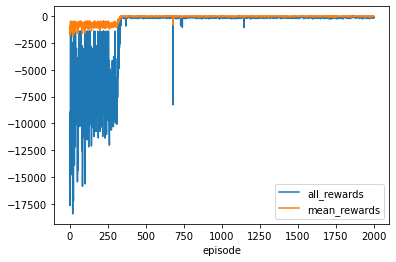

In [16]:
VPG_policy = PolicyNetwork(binomial_env.state_dim, binomial_env.action_dim, 16)
VPG_policy.to(device)
agent = AgentVPG(binomial_env, VPG_policy)

agent.fit()

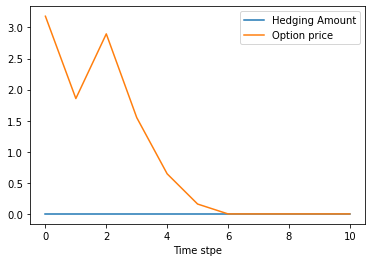

[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [17]:
agent.perform()

# DQN
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [10]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state', 'reward'])

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.index = 0

    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.index] = Transition(state, action, next_state, reward)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [11]:
class Net(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=32):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [12]:
class DQNAgent:
    GAMMA = 0.9
    LearningRate = 3e-4
    BATCH_SIZE = 32
    # EPSILON = 0.9
    Max_Episode = 500
    Capacity = 2000
    Target_network_update = 30

    def __init__(self, env=BinomialTree()):
        self.env = env
        self.eval_net = Net(self.env.state_dim, self.env.action_dim).to(device)
        self.target_net = Net(self.env.state_dim, self.env.action_dim).to(device)
        self.target_net.load_state_dict(self.eval_net.state_dict())

        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=DQNAgent.LearningRate)

        self.memory = ReplayBuffer(DQNAgent.Capacity)
        # self.loss = nn.MSELoss()

    def memorize(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)

    def choose_action(self, state, episode):
        state = torch.unsqueeze(torch.from_numpy(state).float(), dim=0).to(device)
        # epsilon = 0.5*1 / (1 + episode)  # Focus on exploration first and do exploitation next
        epsilon_threshold = 0.05 + (0.9 - 0.05) * np.exp(- episode / 1000)

        if np.random.uniform() < epsilon_threshold:
            # action = [random.sample(self.env.action_space, 1)]
            action = np.random.choice(self.env.action_space)
            # return torch.tensor(action, device=device, dtype=torch.long)
            return action
        else:
            with torch.no_grad():
                return self.eval_net.forward(state).max(1)[1].item() / 10  # TODO: / 10?

    def update_q_function(self):
        if len(self.memory) < DQNAgent.BATCH_SIZE:
            return

        batch = self.memory.sample(DQNAgent.BATCH_SIZE)
        batch = Transition(*zip(*batch))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        non_terminal_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
        non_terminal_next_state_batch = torch.cat([s for s in batch.next_state if s is not None])

        state_action_values = self.eval_net(state_batch).gather(dim=1, index=action_batch)
        next_state_values = torch.zeros(DQNAgent.BATCH_SIZE, device=device)

        with torch.no_grad():
            next_state_values[non_terminal_mask] = self.target_net(non_terminal_next_state_batch).max(dim=1)[0]

        expected_state_action_values = reward_batch + (next_state_values * DQNAgent.GAMMA)
        expected_state_action_values = torch.unsqueeze(expected_state_action_values, 1)

        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.eval_net.parameters(), 100)
        self.optimizer.step()

    def fit(self):
        reward_sum = []
        reward_mean = []

        for eps in range(DQNAgent.Max_Episode):  # 700
            state = self.env.reset()
            rewards = []

            for step in range(15):
                action = self.choose_action(state, eps)

                next_state, reward, done, _ = self.env.step(action)
                rewards.append(reward)

                if done:
                    next_state_m = None
                else:
                    next_state_m = torch.unsqueeze(torch.from_numpy(next_state).float(), dim=0).to(device)
                reward_m = torch.tensor([reward], device=device)
                state_m = torch.unsqueeze(torch.from_numpy(state).float(), dim=0).to(device)
                action_m = torch.tensor([[int(action * 10)]], device=device)
                self.memorize(state_m, action_m, next_state_m, reward_m)

                state = next_state
                self.update_q_function()

                if done:
                    print(f'episode: {eps}, steps: {step}, total_reward: {sum(rewards)}, mean_reward: {np.mean(rewards)}')
                    break

            if eps % DQNAgent.Target_network_update == 0:  # Update Network parameters after 30 times
                self.target_net.load_state_dict(self.eval_net.state_dict())
            reward_sum.append(np.sum(rewards))
            reward_mean.append(np.mean(rewards))

        plt.plot(reward_sum)
        plt.plot(reward_mean)
        plt.legend(['sum_rewards', 'mean_rewards'])
        plt.xlabel('episode')
        plt.show()
        return


In [13]:
DQN_policy = DQNAgent(binomial_env)

episode: 0, steps: 9, total_reward: -29786.357674671737, mean_reward: -2978.6357674671744
episode: 1, steps: 9, total_reward: -22368.035155652855, mean_reward: -2236.803515565286
episode: 2, steps: 4, total_reward: -9852.79962863771, mean_reward: -1970.559925727542
episode: 3, steps: 8, total_reward: -43795.23190976921, mean_reward: -4866.136878863245
episode: 4, steps: 8, total_reward: -25320.478408327825, mean_reward: -2813.386489814203
episode: 5, steps: 6, total_reward: -17278.966543695955, mean_reward: -2468.423791956565
episode: 6, steps: 9, total_reward: -51292.976321526345, mean_reward: -5129.297632152633
episode: 7, steps: 9, total_reward: -63789.59902077745, mean_reward: -6378.959902077745
episode: 8, steps: 7, total_reward: -30056.206676544905, mean_reward: -3757.0258345681127
episode: 9, steps: 9, total_reward: -71208.21820863211, mean_reward: -7120.821820863212
episode: 10, steps: 4, total_reward: -24266.565272158205, mean_reward: -4853.313054431641


C:\Users\Liaoran\AppData\Local\Temp\ipykernel_21180\941456528.py:56: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  next_state_values[non_terminal_mask] = self.target_net(non_terminal_next_state_batch).max(dim=1)[0]


episode: 11, steps: 9, total_reward: -58083.685679894814, mean_reward: -5808.368567989482
episode: 12, steps: 9, total_reward: -29094.222483998932, mean_reward: -2909.4222483998938
episode: 13, steps: 8, total_reward: -42926.642772372776, mean_reward: -4769.626974708085
episode: 14, steps: 7, total_reward: -43991.450848890025, mean_reward: -5498.931356111252
episode: 15, steps: 2, total_reward: -13956.627662520883, mean_reward: -4652.209220840295
episode: 16, steps: 9, total_reward: -36319.488436261294, mean_reward: -3631.9488436261295
episode: 17, steps: 6, total_reward: -21715.36814511118, mean_reward: -3102.1954493015974
episode: 18, steps: 9, total_reward: -64837.549663729485, mean_reward: -6483.75496637295
episode: 19, steps: 9, total_reward: -27079.8358281418, mean_reward: -2707.9835828141804
episode: 20, steps: 8, total_reward: -10352.699645345258, mean_reward: -1150.2999605939176
episode: 21, steps: 9, total_reward: -51603.61079266791, mean_reward: -5160.36107926679
episode: 22

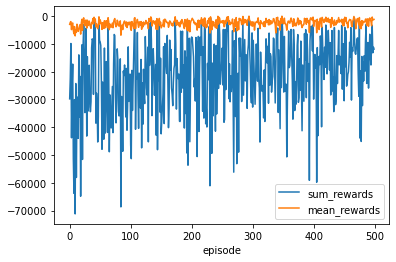

In [14]:
DQN_policy.fit()

# Actor Critic